<a href="https://colab.research.google.com/github/GauravGhatuary/Projects/blob/main/Predictive_maintainanace_milling_machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style('darkgrid')
sns.set_palette('pastel')

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [4]:
data=pd.read_csv('/gdrive/My Drive/Colab Notebooks/Predictive maintainance/ai4i2020.csv')

In [5]:
#Reading the data
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


# **Understanding the data**


This synthetic dataset is modeled after an existing milling machine and consists of 10 000 data points from a stored as rows with 14 features in columns

  **UID**: unique identifier ranging from 1 to 10000

 **product ID**: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number



  **type**: just the product type L, M or H from column 2

  **air temperature** [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K

  **process temperature**[K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.

  **rotational speed** [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise

  **torque**[Nm]: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values.

  **tool wear** [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.

a 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.



The machine failure consists of five independent failure modes

  **tool wear failure** (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).

  **heat dissipation failure** (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.

  **power failure** (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.

  **overstrain failure** (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.

  **random failures** (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.

In [6]:
#Describing the data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
UDI,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.30,300.1,301.50,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.80,310.1,311.10,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.00,1503.0,1612.00,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.20,40.1,46.80,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.00,108.0,162.00,253.0
Machine failure,10000.0,0.03390,0.180981,0.0,0.00,0.0,0.00,1.0
TWF,10000.0,0.00460,0.067671,0.0,0.00,0.0,0.00,1.0
HDF,10000.0,0.01150,0.106625,0.0,0.00,0.0,0.00,1.0
PWF,10000.0,0.00950,0.097009,0.0,0.00,0.0,0.00,1.0


In [7]:
#Removing the non-essential columns
df=data.drop(['UDI','Product ID'],axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Machine failure          10000 non-null  int64  
 7   TWF                      10000 non-null  int64  
 8   HDF                      10000 non-null  int64  
 9   PWF                      10000 non-null  int64  
 10  OSF                      10000 non-null  int64  
 11  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 937.6+ KB


In [9]:
df.columns

Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

In [10]:
feature_variables=['Type', 'Air temperature [K]', 'Process temperature [K]','Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
num_variables=['Air temperature [K]', 'Process temperature [K]','Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

In [11]:
target_variables=['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF']

Visualizing the distribution of data

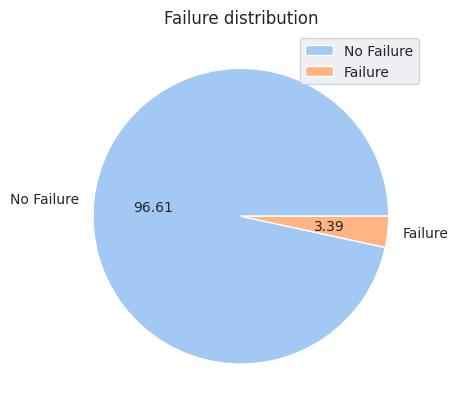

In [12]:
#Plotting failure as piechart
ax=plt.pie(df['Machine failure'].value_counts(),autopct='%.2f',labels=['No Failure','Failure'])
plt.legend(loc='best')
plt.title('Failure distribution')
plt.show()


In [13]:
fail_type=df[['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']].groupby('Machine failure').sum()
fail_type.T

Machine failure,0,1
TWF,0,46
HDF,0,115
PWF,0,95
OSF,0,98
RNF,18,1


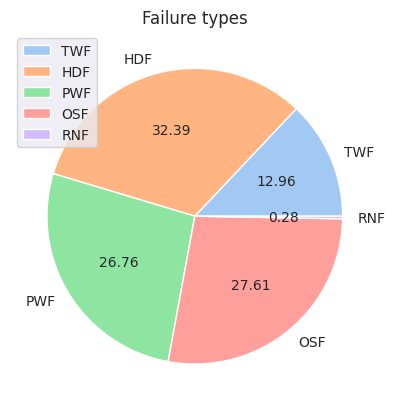

In [14]:
#Plotting failure as piechart
ax=plt.pie(fail_type.loc[1,:],autopct='%.2f',labels=list(fail_type.loc[1,:].index))
plt.legend(loc='best')
plt.title('Failure types')
plt.show()

Since random failures are a very small part of occurence, we can remove it

In [15]:
df=df.drop(['RNF'],axis=1)

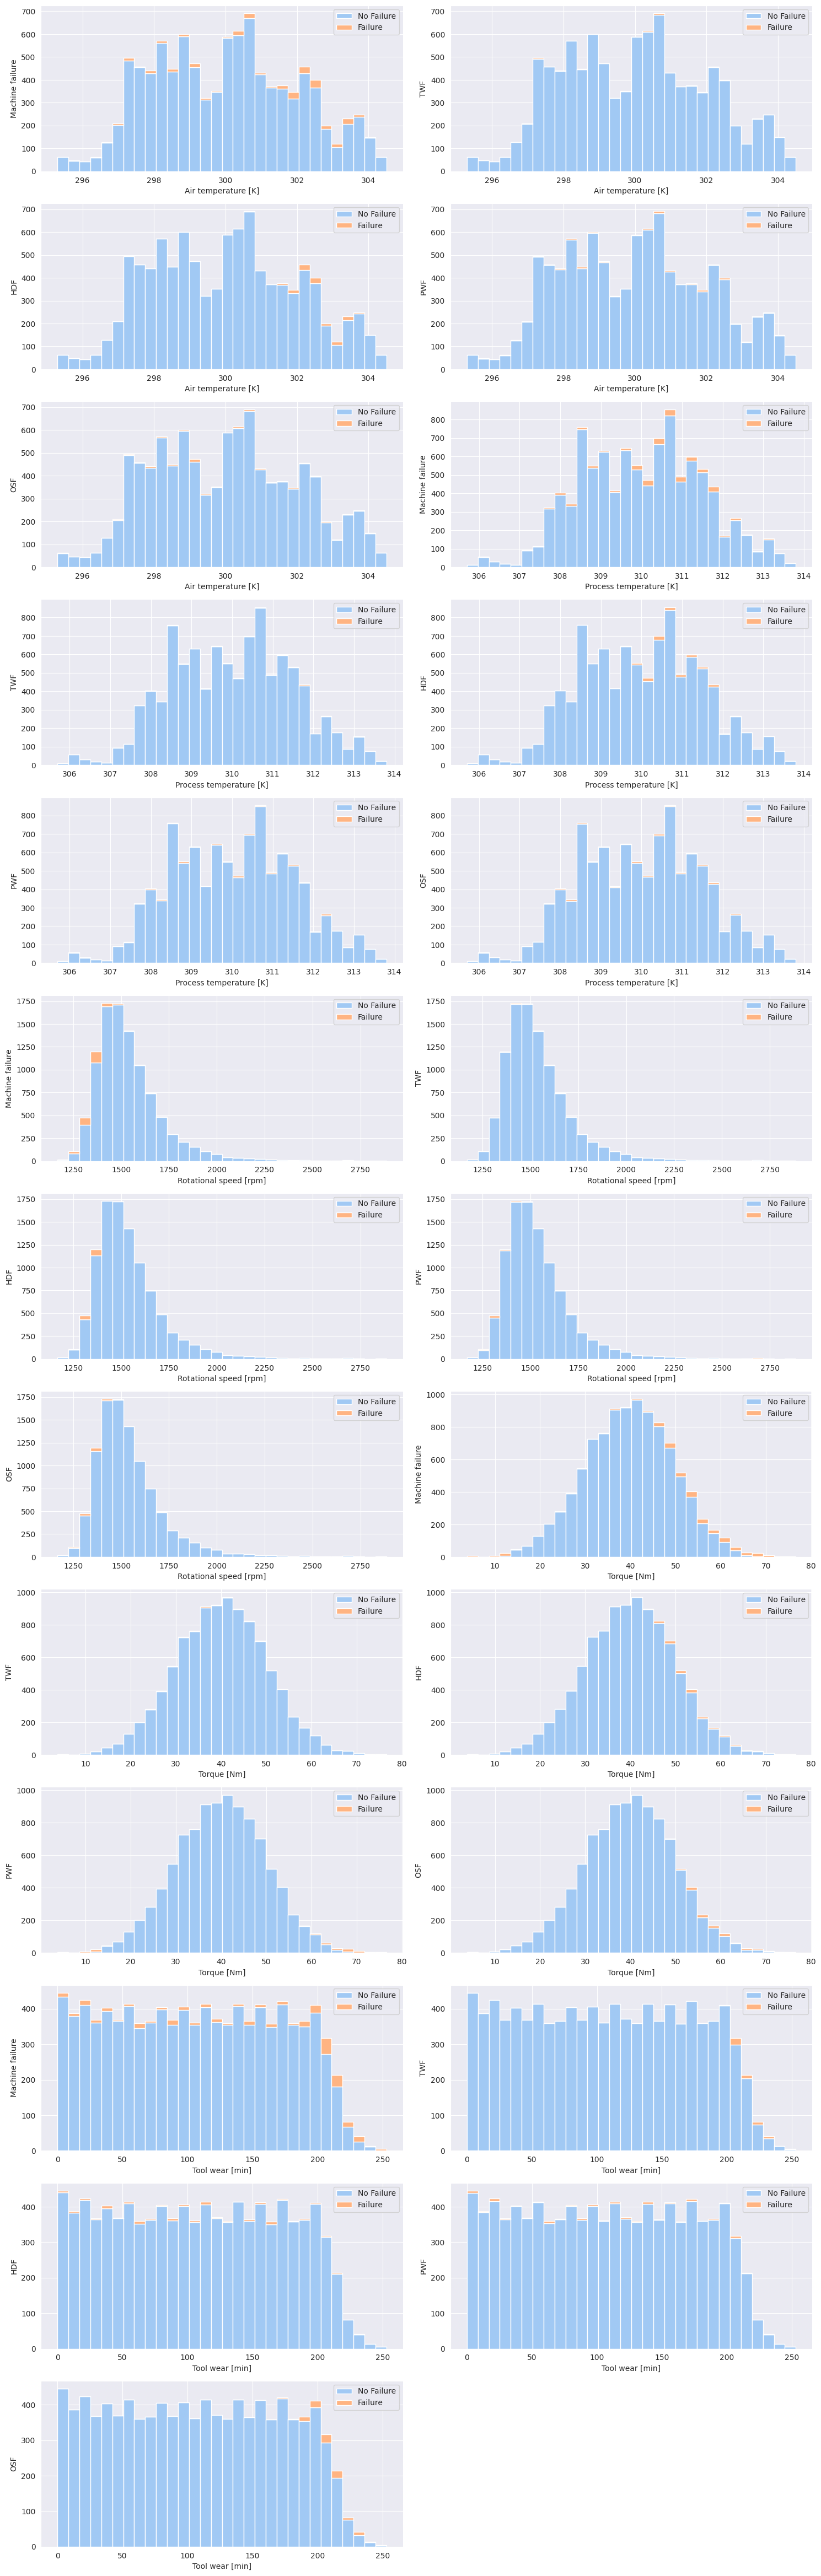

In [16]:
#Plotting numerical variables
k=1
plt.figure(figsize=(15,50))
for i in feature_variables[1:]:

  for j in target_variables:
    ax=plt.subplot(14, 2, k)
    plt.hist([df[df[j]==0][i],df[df[j]==1][i]],stacked=True,bins=30,label=['No Failure','Failure'])
    k+=1
    plt.xlabel(i)
    plt.ylabel(j)
    plt.legend()
    plt.tight_layout()

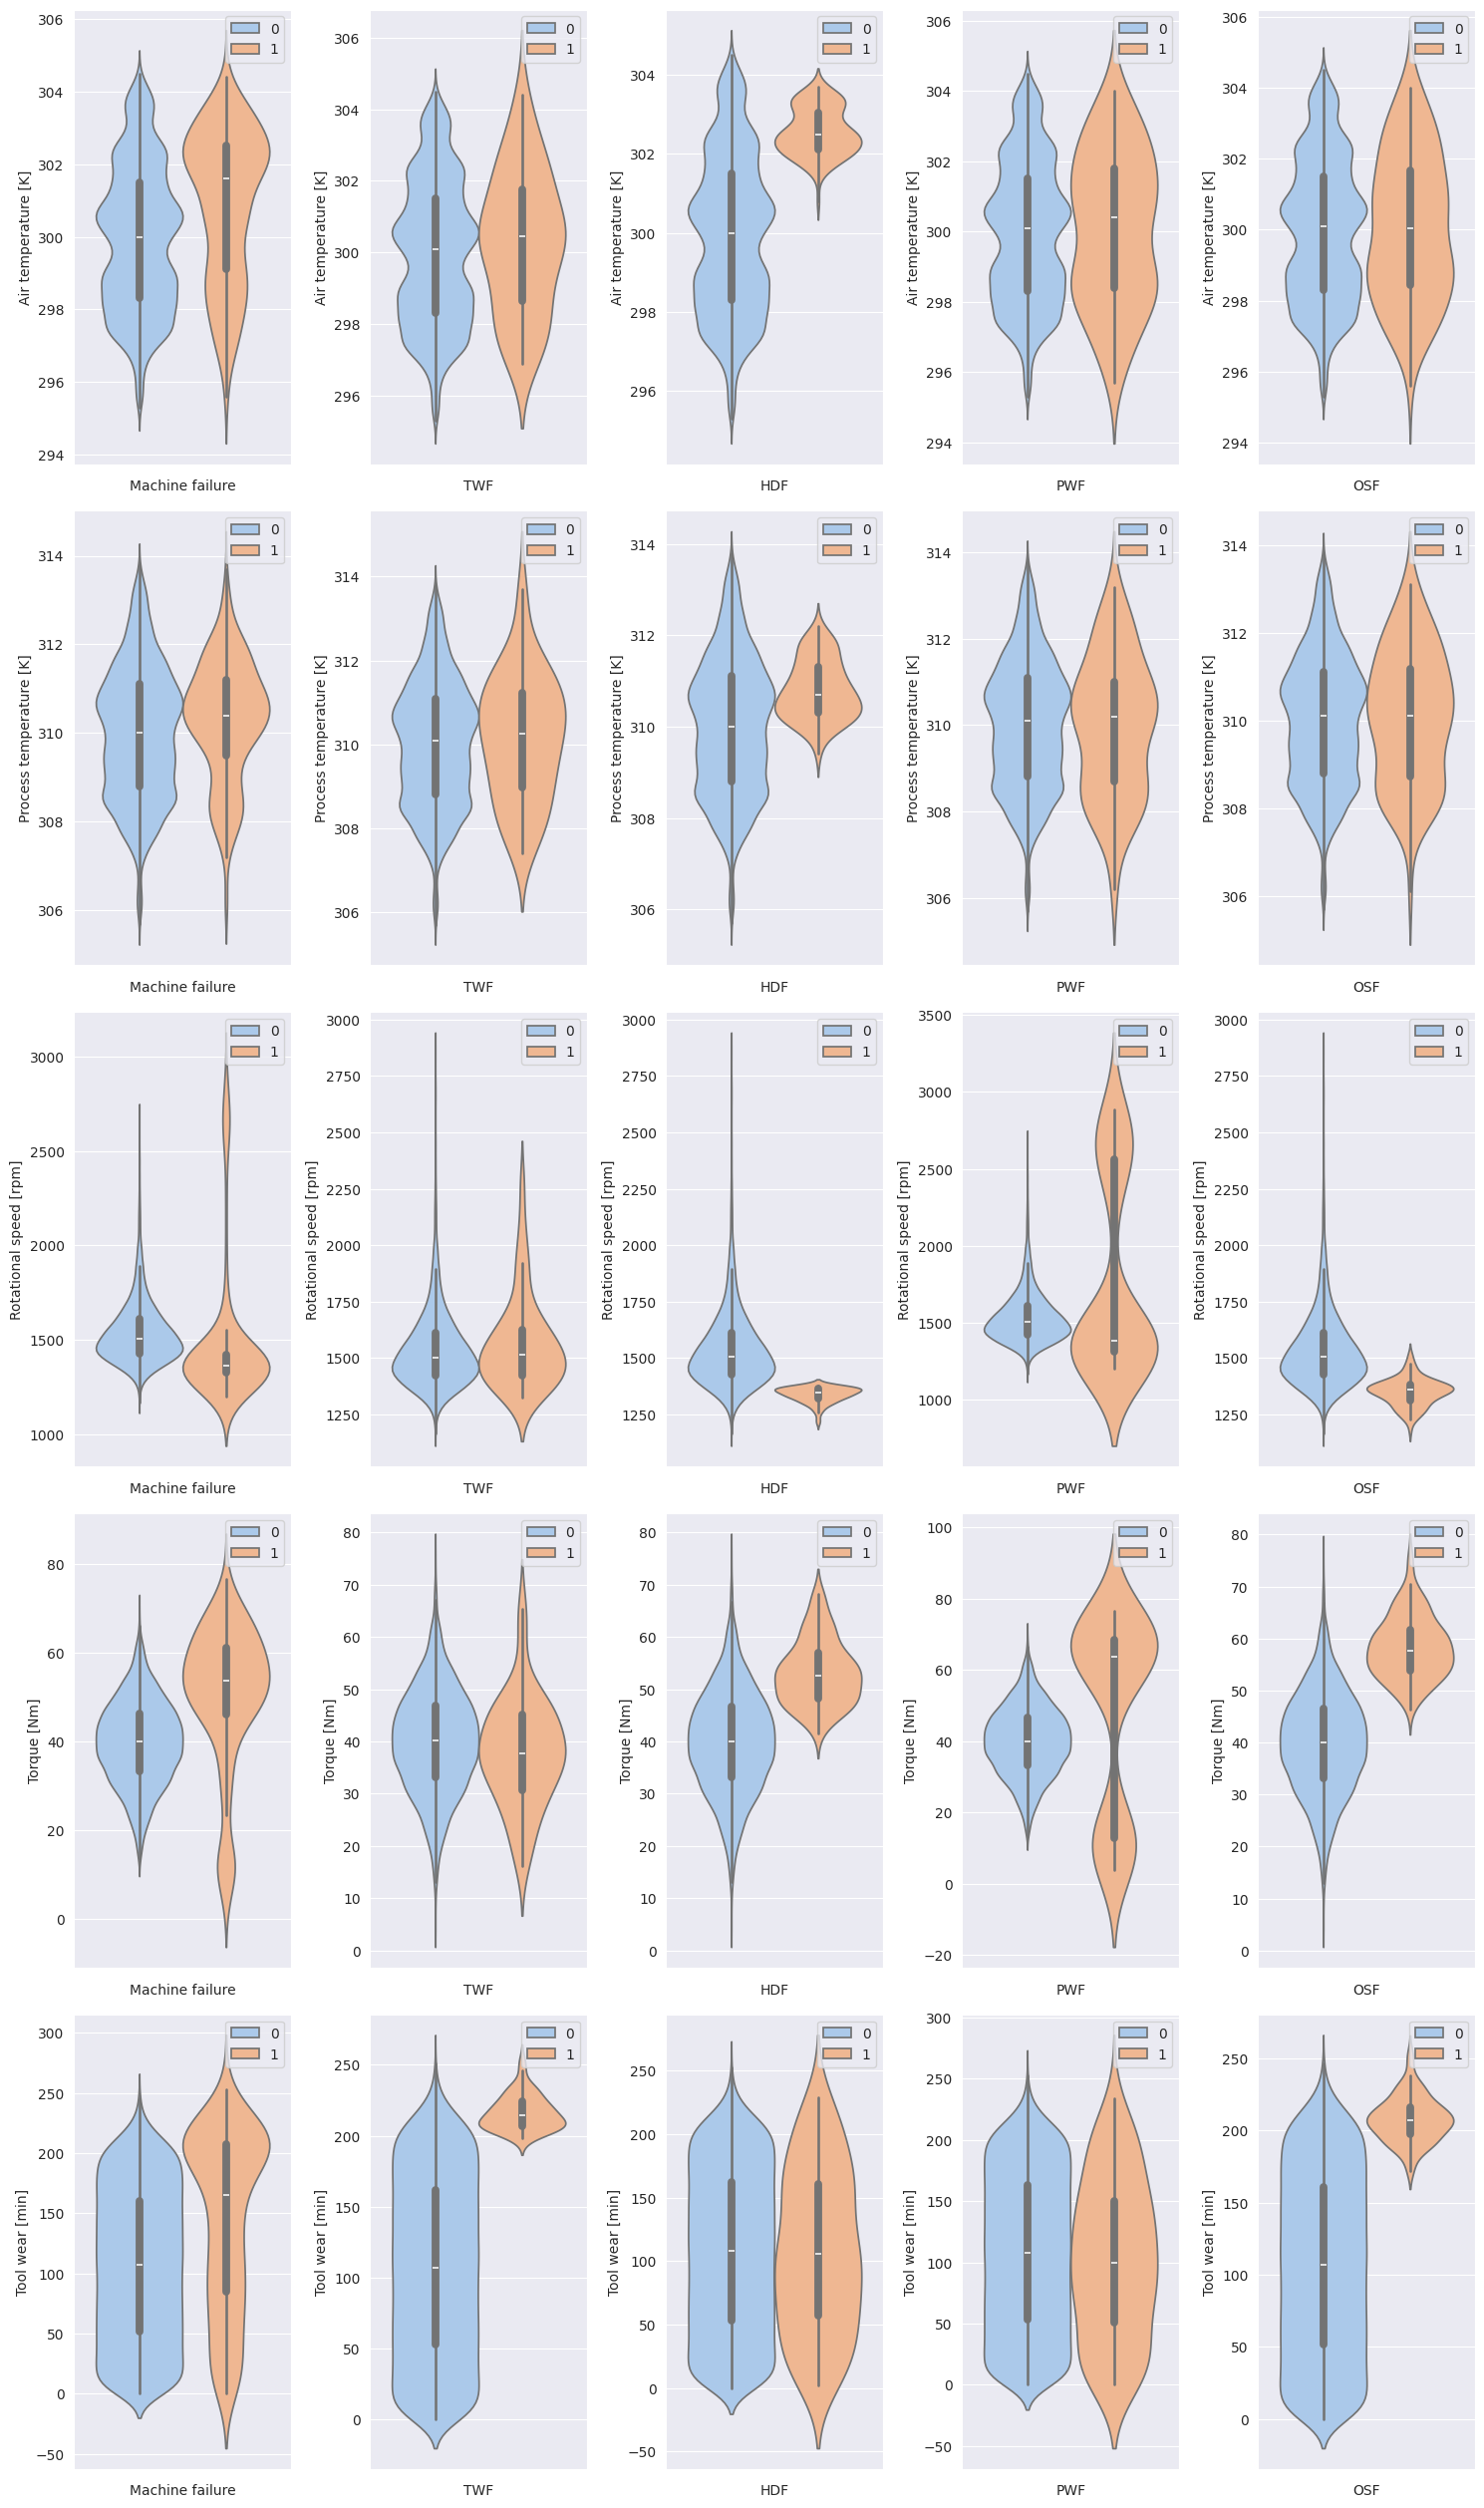

In [17]:
#Plotting categorical variables wrt failure using boxplots
k=1
plt.figure(figsize=(15,30))
for i in feature_variables[1:]:

  for j in target_variables:
    ax=plt.subplot(6, 5, k)
    sns.violinplot(df,y=i,hue=j,ax=ax)
    k+=1
    plt.xlabel(j)
    plt.ylabel(i)
    plt.legend()
    plt.tight_layout()

From above plots, we can observe that some failures are heavily dependent on some parameters:

*   TWF Failure likely occurs on High Tool wear

*   HDF Failure is strongly correlated with High Air Temperature,High Process Temperature,Lower Rotational speed,Higher Torque

*   PWF Failure is  associated mostly with Extreme high and extreme low rotational speeds and Torque


*   OSF Failure is  associated with lower rotational speeds,higher torque and High tool wear





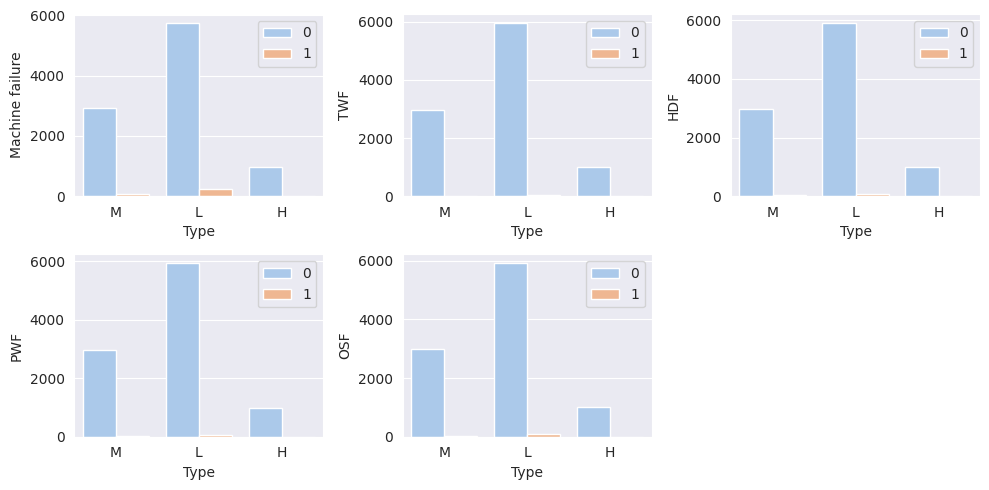

In [18]:
#Plotting categorical variables
k=1
plt.figure(figsize=(10,5))

for j in target_variables:
  ax=plt.subplot(2, 3, k)
  sns.countplot(df,x='Type',hue=j,ax=ax)
  k+=1
  plt.xlabel('Type')
  plt.ylabel(j)
  plt.legend()
  plt.tight_layout()

In [19]:
type_df=df.groupby('Type')[target_variables].sum().transpose()
type_df.loc['Total']=dict(df['Type'].value_counts())
type_df=type_df/type_df.loc['Total']*100
type_df

Type,H,L,M
Machine failure,2.093719,3.916667,2.769436
TWF,0.697906,0.416667,0.467134
HDF,0.797607,1.266667,1.034368
PWF,0.498504,0.983333,1.034368
OSF,0.199402,1.450000,0.300300
Total,100.000000,100.000000,100.000000


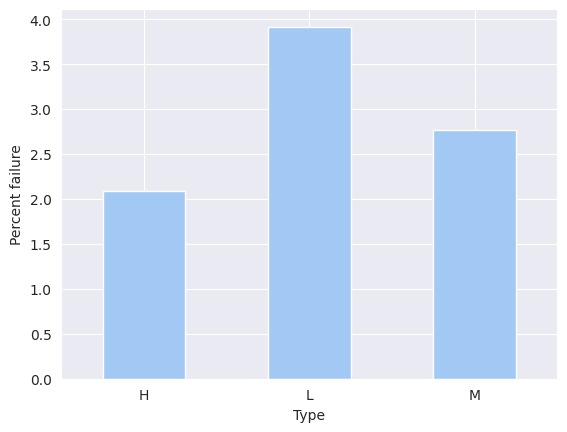

In [20]:
type_df.transpose()['Machine failure'].plot(kind='bar',stacked=True)
plt.xticks(rotation=0)
plt.ylabel('Percent failure')
plt.show()

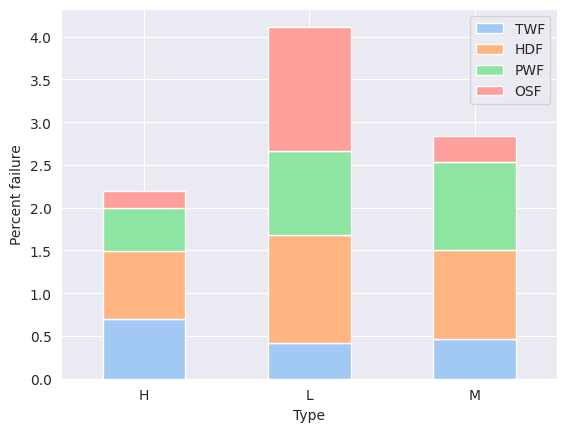

In [21]:
#Plotting different types of failure with types
type_df.transpose()[['TWF','HDF','PWF','OSF']].plot(kind='bar',stacked=True)
plt.xticks(rotation=0)
plt.ylabel('Percent failure')
plt.show()

From above plot, it is observed that L type machines have a higher rate of failure with OSF failure mostly occuring in this type

In [22]:
#Checking whether there are multiple types of failure for same instance
temp=df[['TWF','HDF','PWF','OSF']]
temp['Failure_Type']=temp.apply(lambda x:sum(x),axis=1)
temp['Failure_Type'].value_counts()

<ipython-input-22-aa71dfc80ec0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Failure_Type']=temp.apply(lambda x:sum(x),axis=1)


,count
Failure_Type,
0,9670
1,307
2,22
3,1


In [23]:
temp[temp['Failure_Type'].isin([2,3])]

,TWF,HDF,PWF,OSF,Failure_Type
69,0,0,1,1,2
1324,0,0,1,1,2
1496,0,0,1,1,2
3854,0,0,1,1,2
3943,0,0,1,1,2
4254,0,1,1,0,2
4342,0,1,1,0,2
4370,0,1,0,1,2
4383,0,1,0,1,2
4417,0,1,1,0,2


As we can see, these type of failures can appear simultaneously, we can frame this question as binary classification for each of 4 types.

If we frame this question as multi-class classification, there will be  4 classes of single-type failure,6 classes combination of 2 types of failure  + 1 class of three types of failure with a total of 13 classes.

With very low no of occurences for each class, we might not have enough data to train such a model.


Since the no of instances for 4 types of failure is also low, we will train 4 types of binary models for each failure, as it will be more practical




In [24]:
#Encoding 'Type'  column to  binary variable
dfm=pd.get_dummies(df,columns=['Type'],dtype='int')


In [25]:

dfm

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,Type_H,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,0,1
1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,1,0
2,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,1,0
3,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,1,0
4,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,298.8,308.4,1604,29.5,14,0,0,0,0,0,0,0,1
9996,298.9,308.4,1632,31.8,17,0,0,0,0,0,1,0,0
9997,299.0,308.6,1645,33.4,22,0,0,0,0,0,0,0,1
9998,299.0,308.7,1408,48.5,25,0,0,0,0,0,1,0,0


<Axes: >

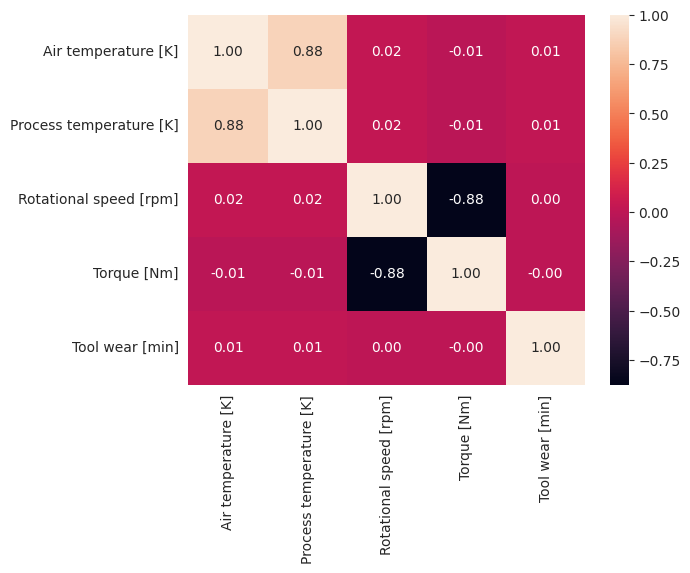

In [26]:
# Checking correlation
corr=dfm[num_variables].corr(numeric_only=True)
sns.heatmap(corr,annot=True,fmt='.2f')

Air temp & process temperature seems to have a very strong correlation


In [27]:
dfm[target_variables].sum()

,0
Machine failure,339
TWF,46
HDF,115
PWF,95
OSF,98


Predicting HDF failure, since it has max occurence

# **Predicting HDF Failure**

In [28]:
#Defining the feature & target data
X=dfm.drop(target_variables,axis=1)
y=dfm['HDF']

In [29]:
#Scaling the data

In [30]:
from sklearn.preprocessing import StandardScaler

In [31]:
scaler=StandardScaler()
X_s=scaler.fit_transform(X)


In [32]:
#Splitting into train & test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X_s,y,test_size=0.2,stratify=y,shuffle=True)

In [33]:
print(f'Shape of training data:{X_train.shape}')
print(f'Shape of test data:{X_test.shape}')

Shape of training data:(8000, 8)
Shape of test data:(2000, 8)


In [34]:
y_test.value_counts()

,count
HDF,
0,1977
1,23


We can see that this is a highly imbalanced data,still we will not do any oversampling, instead we will class weights to give higher weight to positive instances during training

**Feature Selection**

In [35]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

In [36]:
selector=SelectKBest(score_func=mutual_info_classif,k='all')

In [37]:
selector.fit(X_train,y_train)

SelectKBest(k='all',
            score_func=<function mutual_info_classif at 0x7aef261068c0>)

In [38]:
feature_scores=selector.scores_

In [39]:
feature_score_df=pd.DataFrame({'Feature_names':X.columns,'Feature Scores':feature_scores})
feature_score_df.sort_values('Feature Scores',ascending=False,ignore_index=True)

,Feature_names,Feature Scores
0,Rotational speed [rpm],0.022929
1,Air temperature [K],0.017497
2,Torque [Nm],0.012728
3,Process temperature [K],0.007360
4,Type_L,0.002249
5,Type_H,0.001816
6,Tool wear [min],0.000000
7,Type_M,0.000000


This implies that HDF is mostly influenced by 4 factors, we will use this infomormation if our model is not optimal while taking all features

In [40]:
# Importing libraries

In [41]:
from sklearn import metrics

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [43]:
#Using class weights to balance
from sklearn.utils.class_weight import compute_class_weight

Calculating sample weights to balance the data

In [44]:
neg_nos=len(y_train[y_train==0])
pos_nos=len(y_train[y_train==1])
print(f'Positive samples:{pos_nos} ,Negative sample:{neg_nos}')
total_nos=neg_nos+pos_nos

Positive samples:92 ,Negative sample:7908


In [45]:
class_wt=compute_class_weight('balanced',classes=np.unique(y_train),y=y_train)
class_wt

array([ 0.50581689, 43.47826087])

In [46]:
class_wt_dict={0:total_nos/(neg_nos*2),1:total_nos/(pos_nos*2)}
class_wt_dict

{0: 0.5058168942842691, 1: 43.47826086956522}

### **Defining a metrics**

For imbalanced data , it is better to use F1-macro since it gives equal weightage to both positive and negative instance

In [47]:
from sklearn.metrics import f1_score

### **Random Forest Classifier**

In [48]:
rfmodel=RandomForestClassifier(n_estimators=500, n_jobs=-1,class_weight=class_wt_dict)


In [49]:
rfmodel.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 0.5058168942842691,
                                     1: 43.47826086956522},
                       n_estimators=500, n_jobs=-1)

In [50]:
y_pred=rfmodel.predict(X_test)

In [51]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1977
           1       1.00      0.61      0.76        23

    accuracy                           1.00      2000
   macro avg       1.00      0.80      0.88      2000
weighted avg       1.00      1.00      0.99      2000



In [52]:
#Defining a confusion matrix function
def display_conf_matrix(y_test,y_pred,title):

  conf_matrix=metrics.confusion_matrix(y_test,y_pred)
  matrix=metrics.ConfusionMatrixDisplay(conf_matrix,display_labels=rfmodel.classes_)

  plt.figure(figsize=(1,1))
  matrix.plot(cmap='Blues')
  plt.grid(False)
  plt.title(title)
  plt.show()

<Figure size 100x100 with 0 Axes>

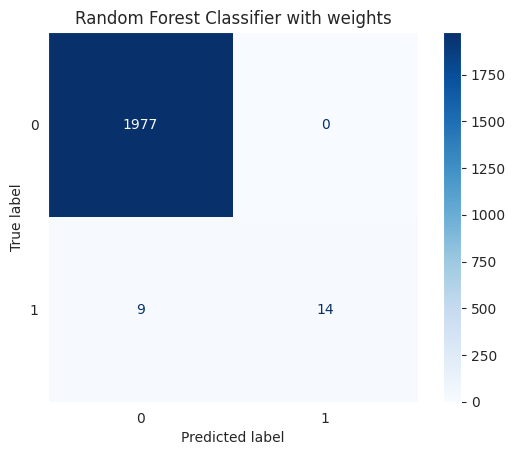

In [53]:
display_conf_matrix(y_test,y_pred,'Random Forest Classifier with weights')

In [54]:
score_rf=f1_score(y_test,y_pred,average='macro')
print(f'Score of Random Forest Classifier:{score_rf:.2f}')

Score of Random Forest Classifier:0.88


We can see that there is higher case of False Negative.

Lets see if we can improve upon the performance by using **Feature Selection**

### **Using the most 4 important features**

In [55]:
selector4=SelectKBest(score_func=mutual_info_classif,k=4)

In [56]:
X_train_r=selector4.fit_transform(X_train,y_train)
X_test_r=selector4.transform(X_test)

In [57]:
rfmodel=RandomForestClassifier(n_estimators=500, n_jobs=-1,max_depth=10,class_weight=class_wt_dict)
rfmodel.fit(X_train_r,y_train)

RandomForestClassifier(class_weight={0: 0.5058168942842691,
                                     1: 43.47826086956522},
                       max_depth=10, n_estimators=500, n_jobs=-1)

In [58]:
y_pred=rfmodel.predict(X_test_r)
y_pred_prob=rfmodel.predict_proba(X_test_r)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1977
           1       0.83      0.87      0.85        23

    accuracy                           1.00      2000
   macro avg       0.92      0.93      0.92      2000
weighted avg       1.00      1.00      1.00      2000

Score of Random Forest Classifier with Feature Extraction:0.92


<Figure size 100x100 with 0 Axes>

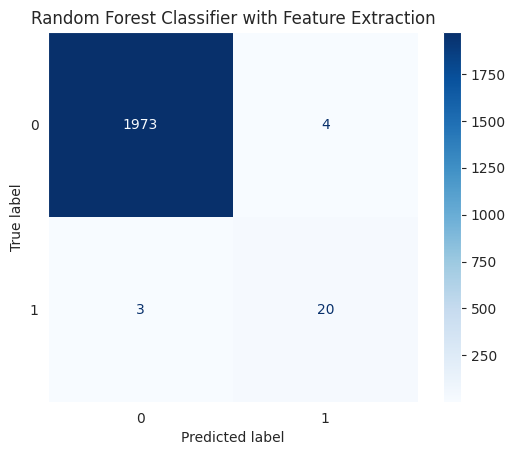

In [59]:
print(metrics.classification_report(y_test,y_pred))

score_rf_fe=f1_score(y_test,y_pred,average='macro')
print(f'Score of Random Forest Classifier with Feature Extraction:{score_rf_fe:.2f}')

display_conf_matrix(y_test,y_pred,'Random Forest Classifier with Feature Extraction')

We can see that there is lower case of False Negative but higher cases of False Positive

Lets see if we can improve upon the performance by using **Oversampling techniques for minority classes**

In [60]:
from imblearn.over_sampling import SMOTE,ADASYN

In [61]:
smote=SMOTE()
adasyn=ADASYN()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1977
           1       0.86      0.83      0.84        23

    accuracy                           1.00      2000
   macro avg       0.93      0.91      0.92      2000
weighted avg       1.00      1.00      1.00      2000

Score of Random Forest Classifier with Oversampling:0.92


<Figure size 100x100 with 0 Axes>

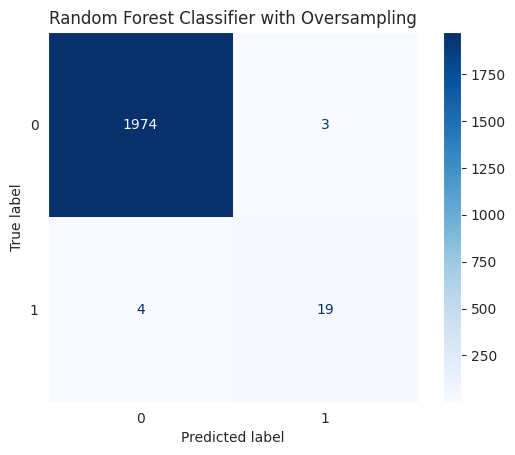

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1977
           1       0.83      0.83      0.83        23

    accuracy                           1.00      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       1.00      1.00      1.00      2000

Score of Random Forest Classifier with Oversampling:0.91


<Figure size 100x100 with 0 Axes>

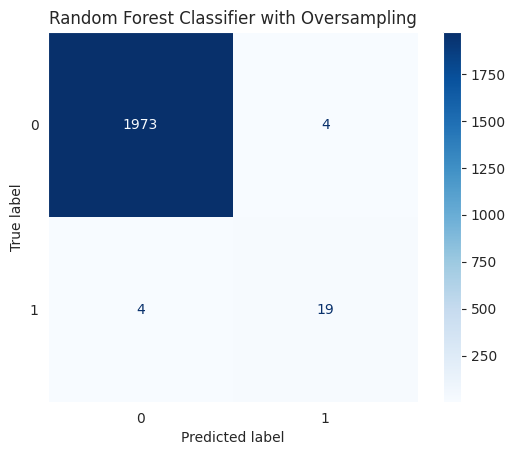

In [62]:
for i in [smote,adasyn]:
  X_train_os,y_train_os=i.fit_resample(X_train_r,y_train)

  rfmodel=RandomForestClassifier(n_estimators=500, n_jobs=-1,max_depth=10)
  rfmodel.fit(X_train_os,y_train_os)
  y_pred=rfmodel.predict(X_test_r)

  print(metrics.classification_report(y_test,y_pred))

  score_rf_os=f1_score(y_test,y_pred,average='macro')
  print(f'Score of Random Forest Classifier with Oversampling:{score_rf_os:.2f}')

  display_conf_matrix(y_test,y_pred,'Random Forest Classifier with Oversampling')


Since ADASYN gives the highest recall, we will choose the adasyn classifier

In [63]:
#Oversampled training data
X_train_os,y_train_os=adasyn.fit_resample(X_train_r,y_train)

In [64]:
#initialising all the ensemble models with default values

adaboost=AdaBoostClassifier(n_estimators=1000)
gbm=GradientBoostingClassifier(n_estimators=1000)
xgb=XGBClassifier(n_estimators=1000,n_jobs=-1)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


<Figure size 100x100 with 0 Axes>

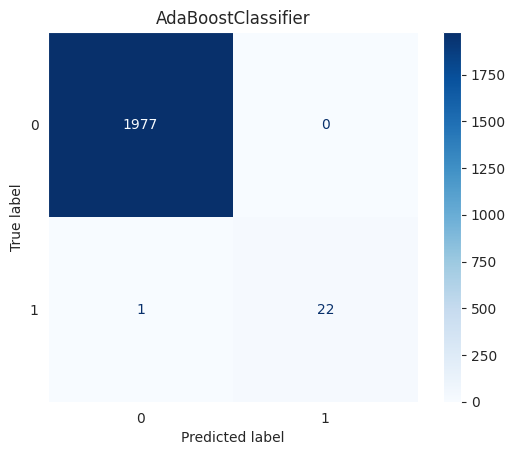

<Figure size 100x100 with 0 Axes>

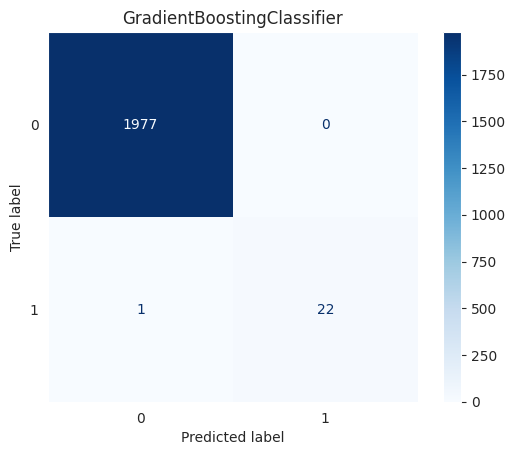

<Figure size 100x100 with 0 Axes>

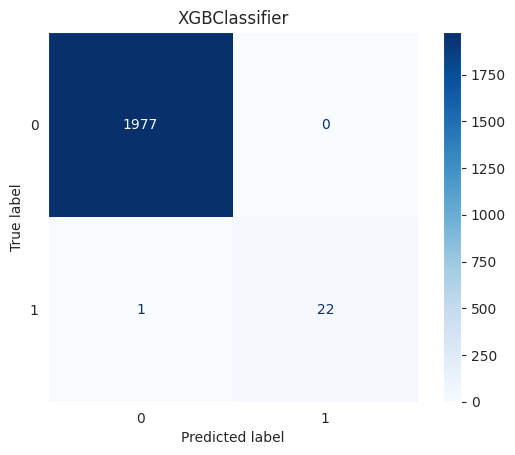

,0
AdaBoostClassifier,0.988762
GradientBoostingClassifier,0.988762
XGBClassifier,0.988762


In [65]:
f_score_dict={}
for i in [adaboost,gbm,xgb]:

  i.fit(X_train_os,y_train_os)
  y_pred=i.predict(X_test_r)

  display_conf_matrix(y_test,y_pred,type(i).__name__)

  f_score_dict[type(i).__name__]=f1_score(y_test,y_pred,average='macro')

pd.Series(f_score_dict)




We can see that all the boosting techniques perform well  with Oversampled data with feature extraction

**We will use the same boosting techniques,adasyn oversampling and 5 best features for each 4 types of failure**

# **Predicting every type of Failures using Boosting**

In [66]:
#Defining a dataframe to store the values
df_failure=pd.DataFrame(np.zeros((3,5)),index=[type(i).__name__ for i in [adaboost,gbm,xgb]],columns=[target_variables[:]])

In [67]:
def model_predict_combined(X,y):
  #Scaling the input variables
  X_s=scaler.fit_transform(X)

  #Splitting into train and test set
  X_train, X_test, y_train, y_test=train_test_split(X_s,y,test_size=0.2,stratify=y,shuffle=True)

  #Extracting the best 5 features
  X_train_r=selector4.fit_transform(X_train,y_train)
  X_test_r=selector4.transform(X_test)

  #Oversampling data with Adasyn
  X_train_os,y_train_os=adasyn.fit_resample(X_train_r,y_train)

  for i in [adaboost,gbm,xgb]:

    i.fit(X_train_os,y_train_os)
    y_pred=i.predict(X_test_r)

    display_conf_matrix(y_test,y_pred,type(i).__name__)

    df_failure.loc[type(i).__name__,y.name]=f1_score(y_test,y_pred,average='macro')


In [68]:
#Target variables
target_variables

['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF']

In [69]:
X=dfm.drop(target_variables,axis=1)

In [70]:
#Defining Target variables
y_h=dfm['HDF']
y_t=dfm['TWF']
y_p=dfm['PWF']
y_o=dfm['OSF']
y_m=dfm['Machine failure']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


<Figure size 100x100 with 0 Axes>

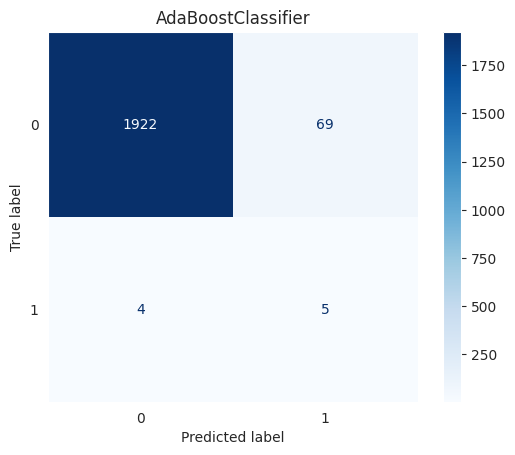

<Figure size 100x100 with 0 Axes>

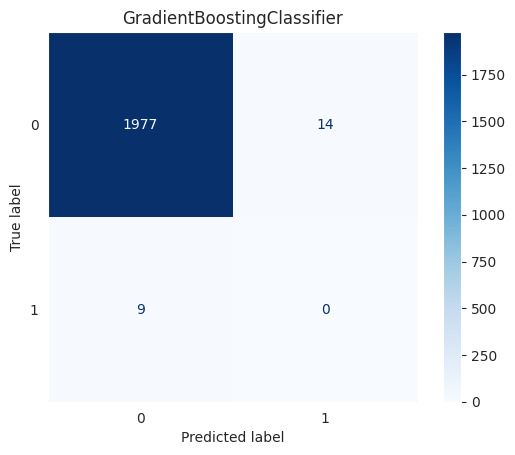

<Figure size 100x100 with 0 Axes>

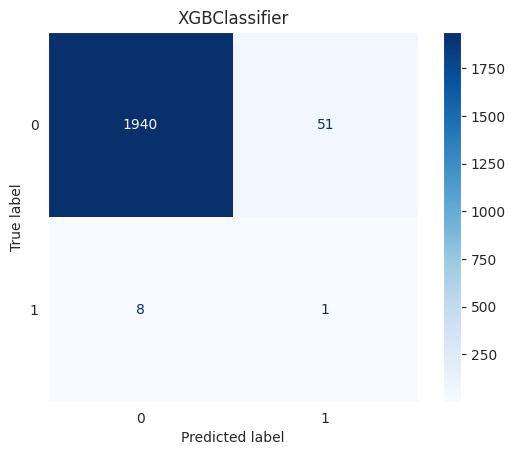

In [71]:
#Predicting TWF Failure
model_predict_combined(X,y_t)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


<Figure size 100x100 with 0 Axes>

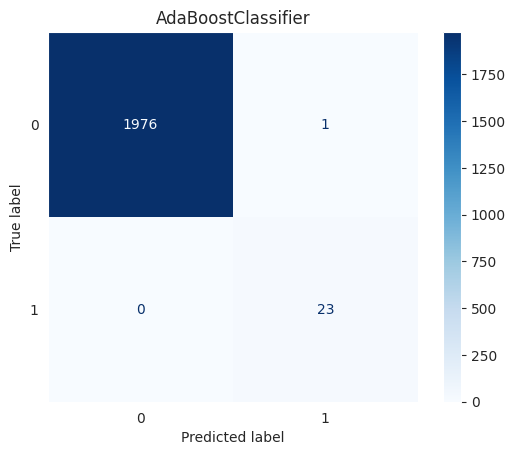

<Figure size 100x100 with 0 Axes>

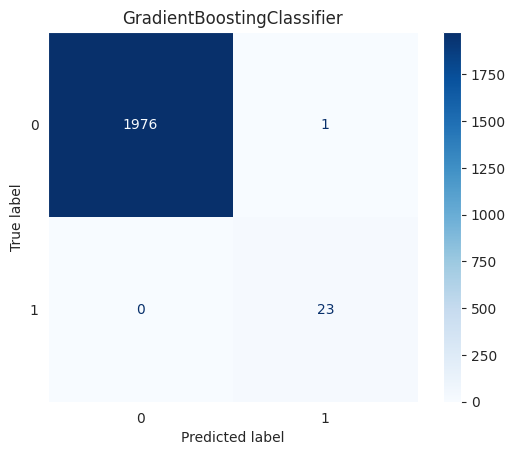

<Figure size 100x100 with 0 Axes>

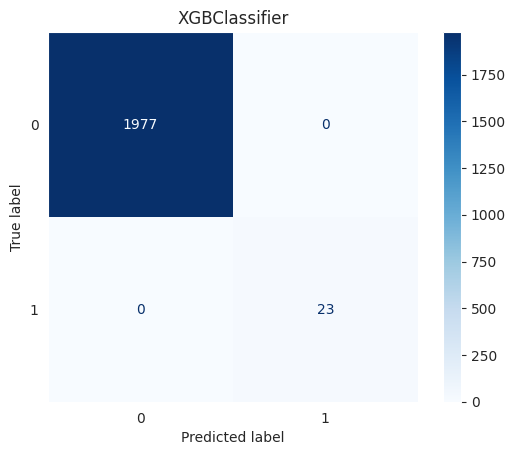

In [72]:
#Predicting HDF Failure
model_predict_combined(X,y_h)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


<Figure size 100x100 with 0 Axes>

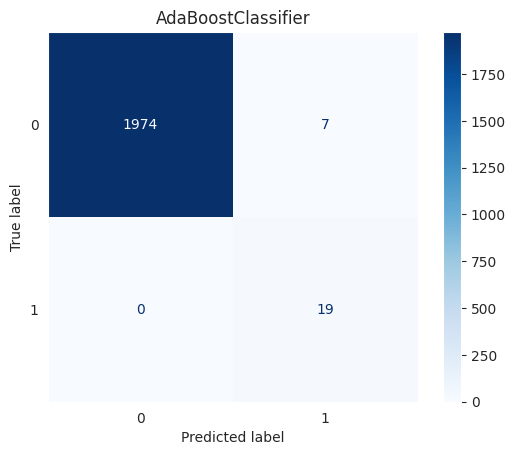

<Figure size 100x100 with 0 Axes>

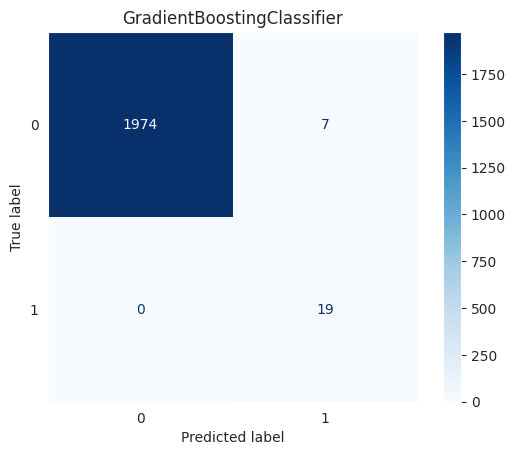

<Figure size 100x100 with 0 Axes>

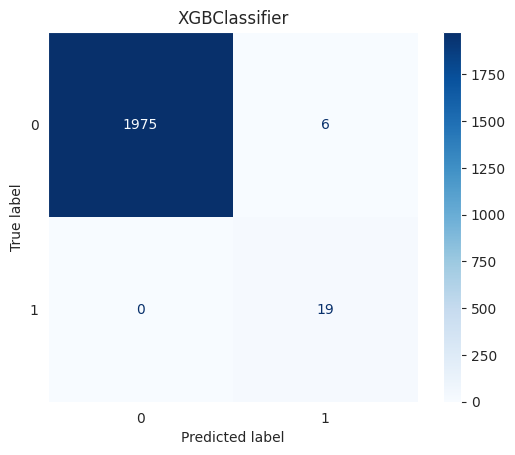

In [73]:
#Predicting PWF Failure
model_predict_combined(X,y_p)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


<Figure size 100x100 with 0 Axes>

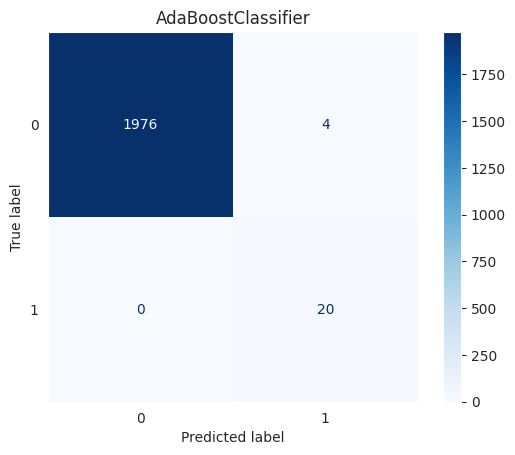

<Figure size 100x100 with 0 Axes>

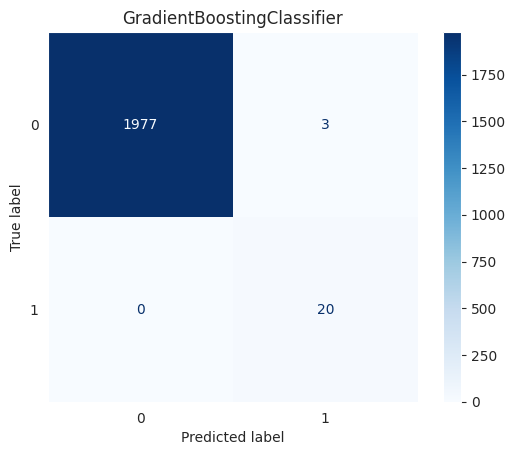

<Figure size 100x100 with 0 Axes>

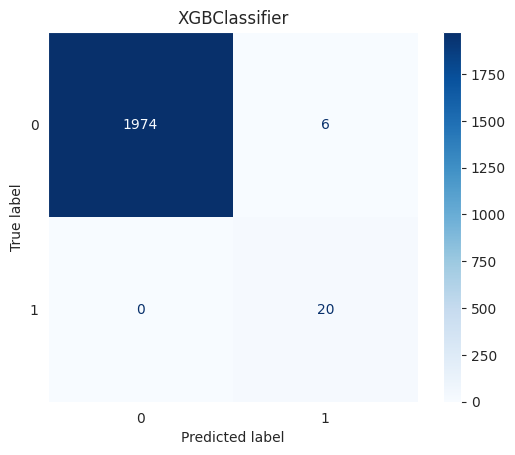

In [74]:
#Predicting OSF Failure
model_predict_combined(X,y_o)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


<Figure size 100x100 with 0 Axes>

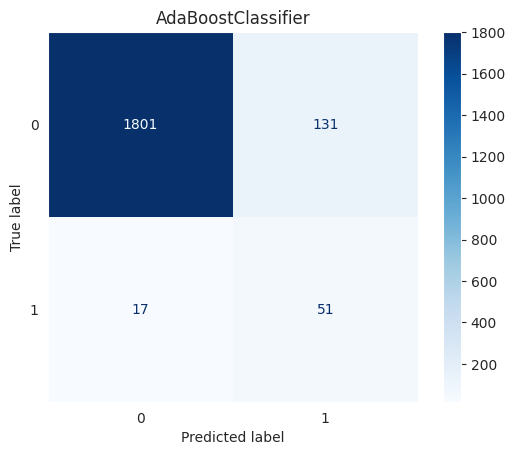

<Figure size 100x100 with 0 Axes>

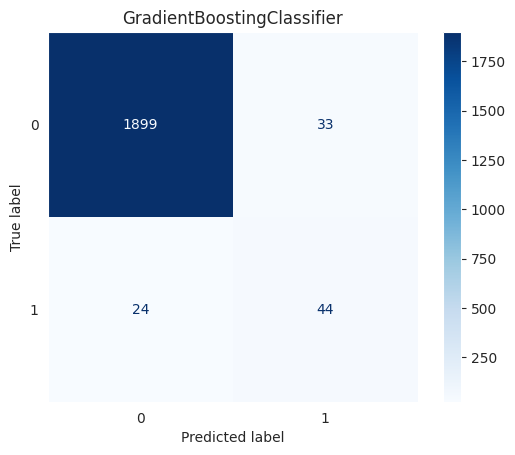

<Figure size 100x100 with 0 Axes>

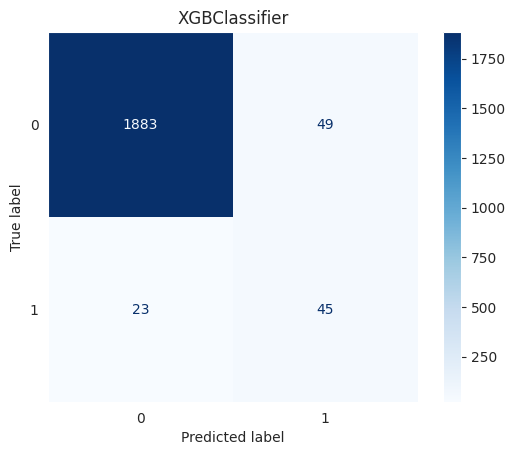

In [75]:
#Predicting  overall machine Failure
model_predict_combined(X,y_m)

In [76]:
df_failure=np.round(df_failure,2)
df_failure

,Machine failure,TWF,HDF,PWF,OSF
AdaBoostClassifier,0.68,0.55,0.99,0.92,0.95
GradientBoostingClassifier,0.80,0.50,0.99,0.92,0.96
XGBClassifier,0.77,0.51,1.00,0.93,0.93


<Axes: >

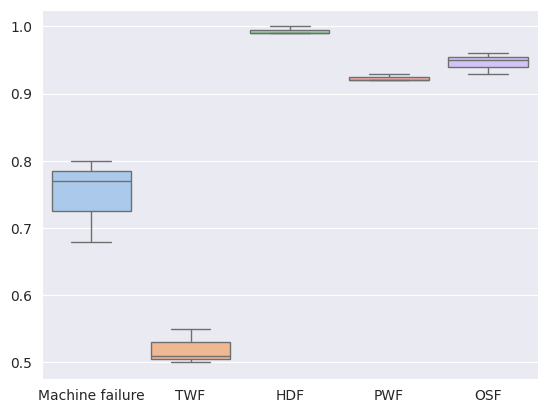

In [77]:
sns.boxplot(df_failure)

With boosting algorithms, we observe that we can classify HDF,PWF & OSF  Failure accurately but TWF failure is hard to predict.

There can be various reasons for this incl. lack of data or important feature missing


In [78]:
df_failure_m=df_failure.melt(ignore_index=False,var_name='Failure Type')
df_failure_m

,Failure Type,value
AdaBoostClassifier,Machine failure,0.68
GradientBoostingClassifier,Machine failure,0.80
XGBClassifier,Machine failure,0.77
AdaBoostClassifier,TWF,0.55
GradientBoostingClassifier,TWF,0.50
XGBClassifier,TWF,0.51
AdaBoostClassifier,HDF,0.99
GradientBoostingClassifier,HDF,0.99
XGBClassifier,HDF,1.00
AdaBoostClassifier,PWF,0.92


Text(0.5, 1.0, 'F1-Score for different Models and failure mode')

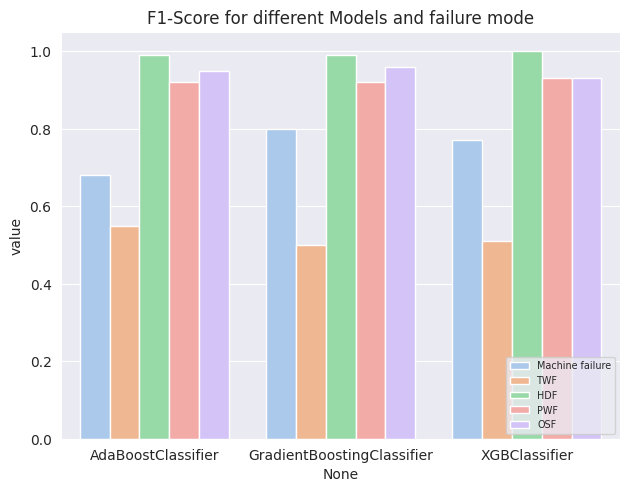

In [79]:
sns.barplot(df_failure_m,x=df_failure_m.index,y='value',hue='Failure Type')
plt.legend(loc='lower right',bbox_to_anchor=(1, 0),fontsize='x-small')
plt.tight_layout()
plt.title('F1-Score for different Models and failure mode')

We can see that **XGBClassifier** works the best overall

Surprisingly AdaBoostClassifier inspite of performing best on individual failures, scores the lowest on overall Machine Failure

### **Tuning XGBoost Classifier**

Tuning on TWF Failure

In [80]:

#Scaling data
X_s=scaler.fit_transform(X)

#Splitting into train and test set
X_train, X_test, y_train, y_test=train_test_split(X_s,y_t,test_size=0.2,stratify=y_t,shuffle=True)

#Extracting the best 4 features
X_train_r=selector4.fit_transform(X_train,y_train)
X_test_r=selector4.transform(X_test)

#Oversampling data with Adasyn
X_train_os,y_train_os=adasyn.fit_resample(X_train_r,y_train)

Using RandomSearchCV to automatically tune

In [81]:
from sklearn.model_selection import RandomizedSearchCV

In [82]:
hyperparameter={'n_estimators':np.arange(100,2000,100),'max_depth':np.arange(10,500,20),'learning_rate':[0.0001,0.001,0.01,0.1]}

In [83]:
random_search=RandomizedSearchCV(XGBClassifier(tree_method = "hist", device = "cuda"),hyperparameter,n_iter=50,n_jobs=-1,verbose=1)

In [84]:
random_search.fit(X_train_os,y_train_os)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cuda',
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=No...
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1],
                                        'max_depth': array([ 10,  30,  50,  70,  90, 110, 130, 150, 170, 190, 210, 230, 250,
       270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 470, 490]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900])},
                   verbose=1)

In [85]:
random_search.best_params_

{'n_estimators': 300, 'max_depth': 230, 'learning_rate': 0.01}

In [86]:
y_pred=random_search.predict(X_test_r)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:24:28] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [87]:
print(metrics.classification_report(y_test,y_pred))

score_xgb=f1_score(y_test,y_pred,average='macro')
print(f'Score of XGB with Feature Extraction & Oversampling:{score_xgb:.2f}')


              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1991
           1       0.06      0.56      0.10         9

    accuracy                           0.96      2000
   macro avg       0.53      0.76      0.54      2000
weighted avg       0.99      0.96      0.97      2000

Score of XGB with Feature Extraction & Oversampling:0.54


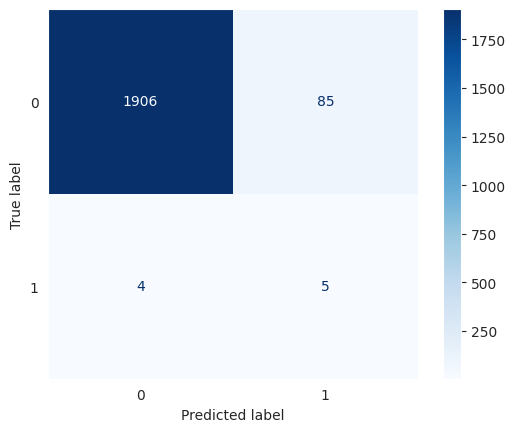

In [88]:
conf_matrix=metrics.confusion_matrix(y_test,y_pred)
matrix=metrics.ConfusionMatrixDisplay(conf_matrix,display_labels=rfmodel.classes_)

matrix.plot(cmap='Blues')
plt.grid(False)

In [89]:
score_xgb=f1_score(y_test,y_pred,average='macro')
print(f'Score of XGB:{score_xgb:.2f}')

Score of XGB:0.54


We have  improved slighly on the TWF failure using revised parameters

# **Applying Neural Network**

In deep learning, we are going to use every features first to evaluate our performnace

In [90]:
from tensorflow import keras

In [91]:
from keras.layers import Dense,Dropout,BatchNormalization,Input,Activation

In [92]:
X=dfm.drop(target_variables,axis=1)
y_t=dfm['TWF']

#Scaling data
X_s=scaler.fit_transform(X)



#Splitting into train and test set
X_train, X_test, y_train, y_test=train_test_split(X_s,y_t,test_size=0.2,stratify=y_t,shuffle=True)

#Extracting the best 5 features
#X_train_r=selector5.fit_transform(X_train,y_train)
#X_test_r=selector5.transform(X_test)


#Oversampling training data with Adasyn
X_train_os,y_train_os=adasyn.fit_resample(X_train,y_train)


#Splitting into train and val set
X_train_a, X_val, y_train_a, y_val=train_test_split(X_train_os,y_train_os,test_size=0.1,stratify=y_train_os,shuffle=True)

In [93]:
pd.Series(y_train_a).value_counts()

,count
TWF,
0,7166
1,7155


In [94]:
#Converting to array
y_train_a=np.array(y_train_a)
y_val=np.array(y_val)
y_test=np.array(y_test)

In [95]:
X_train_a.shape[1]

8

In [96]:
#Modelling a two hidden layer neural network

input=Input(shape=(X_train_a.shape[1],))
x=Dense(512,activation=None, use_bias=False)(input)
x=BatchNormalization()(x)
x=Activation('relu')(x)


x=Dense(512,activation=None, use_bias=False)(x)
x=BatchNormalization()(x)
x=Activation('relu')(x)



x=Dense(512,activation=None, use_bias=False)(x)
x=BatchNormalization()(x)
x=Activation('relu')(x)



output=Dense(1,activation='sigmoid')(x)

model=keras.models.Model(inputs=input,outputs=output)

model.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.001),metrics=['f1_score'],loss='binary_crossentropy')


In [97]:
callback=keras.callbacks.EarlyStopping(monitor='val_f1_score',mode='max',patience=50,restore_best_weights=True)

In [98]:
hist=model.fit(X_train_a,y_train_a.reshape((-1,1)),batch_size=64,epochs=500,validation_data=[X_val,y_val.reshape((-1,1))],callbacks=[callback])

Epoch 1/500
224/224 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - f1_score: 0.6640 - loss: 0.1881 - val_f1_score: 0.6661 - val_loss: 0.1475
Epoch 2/500
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - f1_score: 0.6713 - loss: 0.0993 - val_f1_score: 0.6661 - val_loss: 0.0768
Epoch 3/500
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.6673 - loss: 0.0747 - val_f1_score: 0.6683 - val_loss: 0.0510
Epoch 4/500
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.6689 - loss: 0.0666 - val_f1_score: 0.6723 - val_loss: 0.0770
Epoch 5/500
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.6739 - loss: 0.0766 - val_f1_score: 0.6752 - val_loss: 0.0699
Epoch 6/500
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.6779 - loss: 0.0578 - val_f1_score: 0.6715 - val_loss: 0.0443
Epoch 7/500
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.6709 - loss: 0.0528 - val_f1_score: 0.7341 - val_loss: 0.0876
Epoch 8/500
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.6737 - loss: 0.0580 - val_f1_

In [99]:
y_pred_prob=model.predict(X_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


Text(0, 0.5, 'y_predicted')

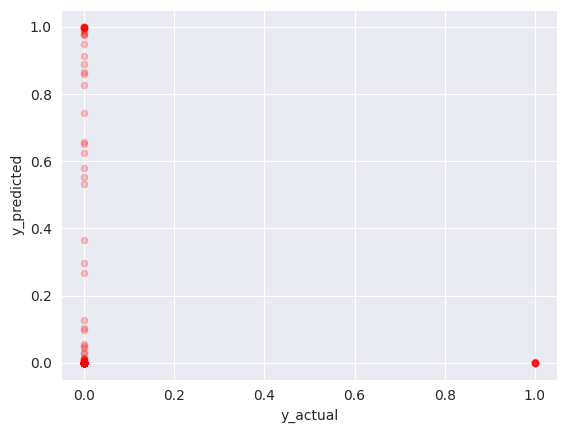

In [100]:
plt.scatter(y_test,y_pred_prob,s=20,alpha=0.2,c='red')
plt.xlabel('y_actual')
plt.ylabel('y_predicted')

In [101]:
y_pred=y_pred_prob.copy()
y_pred[y_pred<0.5]=0
y_pred[y_pred>=0.5]=1


In [102]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1991
           1       0.00      0.00      0.00         9

    accuracy                           0.98      2000
   macro avg       0.50      0.49      0.50      2000
weighted avg       0.99      0.98      0.99      2000



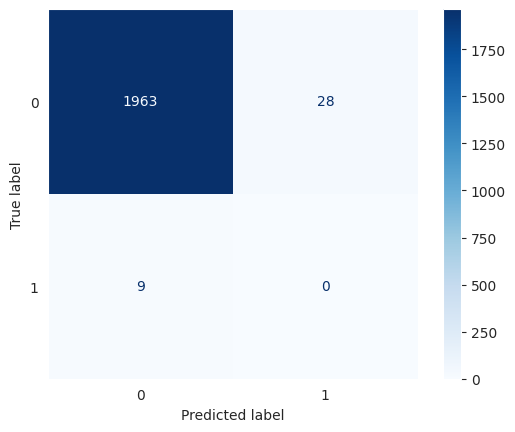

In [103]:
conf_matrix=metrics.confusion_matrix(y_test,y_pred)
matrix=metrics.ConfusionMatrixDisplay(conf_matrix,display_labels=rfmodel.classes_)

matrix.plot(cmap='Blues')
plt.grid(False)

In [104]:
score_nn=f1_score(y_test,y_pred,average='macro')
print(f'Score of Neural network:{score_nn:.2f}')

Score of Neural network:0.50


We can see that the classification of True Positives has improved but there is a also an increase in False Positives.





Using F1-Macro to evaluate metrics

In [105]:
f1_macro=keras.metrics.F1Score(average='macro',name='f1_macro',threshold=0.5)

Using keras tuner to optimize f1_macro

In [106]:
!pip install keras-tuner -q

In [107]:
import keras_tuner

In [108]:
def model_f(hp):


  units=hp.Int("units", min_value=128, max_value=1024, step=64)
  layers=hp.Int("layers", min_value=1, max_value=4, step=1)
  lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, step=10, sampling='log')
  activation=hp.Choice('activation',  ['relu'])


  input=Input(shape=(X_train.shape[1],))

  x=Dense(units,activation=None, use_bias=False)(input)
  x=BatchNormalization()(x)
  x=Activation(activation)(x)

  for i in range(layers):
    x=Dropout(0.2)(x)
    x=Dense(units,activation=None, use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Activation(activation)(x)


  output=Dense(1,activation='sigmoid')(x)

  model=keras.models.Model(inputs=input,outputs=output)

  model.compile(optimizer=keras.optimizers.Nadam(learning_rate=lr),metrics=[f1_macro],loss='binary_crossentropy')

  return model


In [109]:
hp=keras_tuner.HyperParameters()

In [112]:
#Defining tuner
tuner = keras_tuner.Hyperband(
    hypermodel=model_f,
    objective=keras_tuner.Objective("val_loss", direction="min"),
    max_epochs=50,
    overwrite=True
)

In [113]:
tuner.search(X_train_a,y_train_a.reshape((-1,1)),batch_size=128,epochs=100,validation_data=[X_val,y_val.reshape((-1,1))])

Trial 85 Complete [00h 00m 40s]
val_loss: 0.021191738545894623

Best val_loss So Far: 0.019036898389458656
Total elapsed time: 00h 24m 02s


In [114]:
#Getting best hyper parameters
best_hparams=tuner.get_best_hyperparameters()[0]
print(f"Best units: {best_hparams.get('units')}\nBest layers: {best_hparams.get('layers')}\nBest learning rate: {best_hparams.get('learning_rate')}")

Best units: 256
Best layers: 2
Best learning rate: 0.001


In [115]:
#Defining model with best hyperparameters

input=Input(shape=(X_train.shape[1],))

x=Dense(best_hparams.get('units'),activation=None, use_bias=False)(input)
x=BatchNormalization()(x)
x=Activation('relu')(x)

for i in range(best_hparams.get('layers')):
  x=Dropout(0.2)(x)
  x=Dense(best_hparams.get('units'),activation=None, use_bias=False)(x)
  x=BatchNormalization()(x)
  x=Activation('relu')(x)


output=Dense(1,activation='sigmoid')(x)

model=keras.models.Model(inputs=input,outputs=output)

model.compile(optimizer=keras.optimizers.Nadam(learning_rate=best_hparams.get('learning_rate')),metrics=[f1_macro],loss='binary_crossentropy')



In [116]:
callback=keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=50,restore_best_weights=True)

In [117]:
hist=model.fit(X_train_a,y_train_a.reshape((-1,1)),batch_size=64,epochs=500,validation_data=[X_val,y_val.reshape((-1,1))],callbacks=[callback])

Epoch 1/500
224/224 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - f1_macro: 0.9366 - loss: 0.2427 - val_f1_macro: 0.9578 - val_loss: 0.1247
Epoch 2/500
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_macro: 0.9587 - loss: 0.1252 - val_f1_macro: 0.9672 - val_loss: 0.1019
Epoch 3/500
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_macro: 0.9623 - loss: 0.1206 - val_f1_macro: 0.9767 - val_loss: 0.0669
Epoch 4/500
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - f1_macro: 0.9698 - loss: 0.0997 - val_f1_macro: 0.9773 - val_loss: 0.0706
Epoch 5/500
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - f1_macro: 0.9741 - loss: 0.0797 - val_f1_macro: 0.9791 - val_loss: 0.0639
Epoch 6/500
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - f1_macro: 0.9760 - loss: 0.0784 - val_f1_macro: 0.9785 - val_loss: 0.0618
Epoch 7/500
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - f1_macro: 0.9784 - loss: 0.0736 - val_f1_macro: 0.9857 - val_loss: 0.0469
Epoch 8/500
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_macro: 0.9777 - loss: 0.0753 - val_f1_

In [118]:
y_pred_prob=model.predict(X_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [119]:
model.evaluate(X_test,y_test.reshape(-1,1))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - f1_macro: 0.1109 - loss: 0.0952


[0.11611977964639664, 0.05714281648397446]

Text(0, 0.5, 'y_predicted')

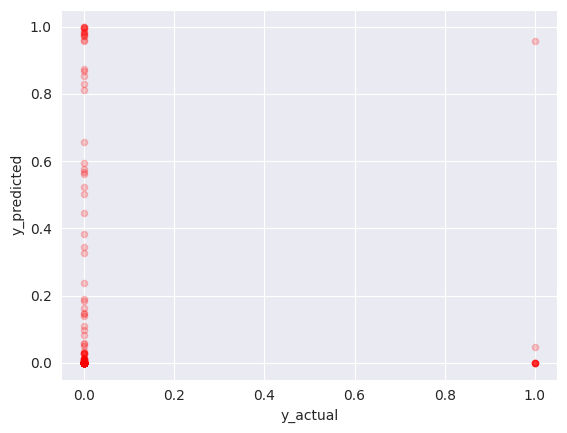

In [120]:
plt.scatter(y_test,y_pred_prob,s=20,alpha=0.2,c='red')
plt.xlabel('y_actual')
plt.ylabel('y_predicted')

In [121]:
y_pred_prob[y_pred_prob<0.5]=0
y_pred_prob[y_pred_prob>=0.5]=1

In [122]:
print(metrics.classification_report(y_test,y_pred_prob))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1991
           1       0.04      0.11      0.06         9

    accuracy                           0.98      2000
   macro avg       0.52      0.55      0.52      2000
weighted avg       0.99      0.98      0.99      2000



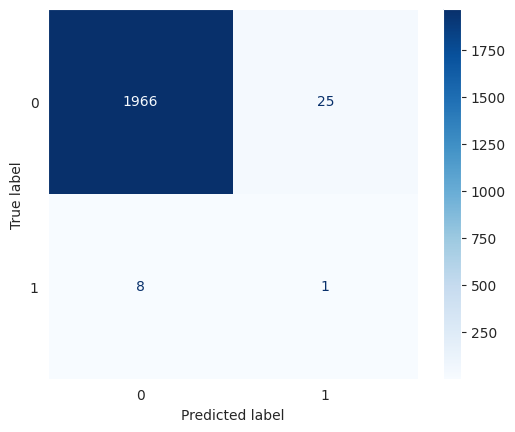

In [123]:
conf_matrix=metrics.confusion_matrix(y_test,y_pred_prob)
matrix=metrics.ConfusionMatrixDisplay(conf_matrix,display_labels=rfmodel.classes_)

matrix.plot(cmap='Blues')
plt.grid(False)

In [125]:
score_nn_tuned=f1_score(y_test,y_pred_prob,average='macro')
print(f'Score of Tuned Neural network:{score_nn_tuned:.2f}')

Score of Tuned Neural network:0.52


# Summary

In [126]:
df_failure

,Machine failure,TWF,HDF,PWF,OSF
AdaBoostClassifier,0.68,0.55,0.99,0.92,0.95
GradientBoostingClassifier,0.80,0.50,0.99,0.92,0.96
XGBClassifier,0.77,0.51,1.00,0.93,0.93


From above table, we can conclude that Tre based Boosting Classifier generally gives the best performance for predicting most of the failures.
While predicting individula failures except TWF, F1 Score is above 90%

TWF Failure is hard to predict even using Neural network, which sugegsts that important features may be missing from data.